In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib import cm, ticker
from sklearn.metrics import classification_report
from tqdm import tqdm

from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.optimizers.approach_gen_disc_loss import ApproachGenDiscLoss
from counterfactuals.losses import BinaryDiscLoss

from counterfactuals.utils import plot_loss_space

In [3]:
def plot_model_distribution(model, median_prob=None, disc_model=None):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20,12)

    xline = torch.linspace(-1.5, 2.5, 200)
    yline = torch.linspace(-.75, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)
    
    with torch.no_grad():
        zgrid0 = model.log_prob(xyinput, torch.zeros(40000, 1)).exp().reshape(200, 200)
        zgrid1 = model.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)

    zgrid0 = zgrid0.numpy()
    zgrid1 = zgrid1.numpy()

    if median_prob is not None:
        median_prob = np.exp(median_prob)
        cs1_mp = ax.contourf(xgrid.numpy(), ygrid.numpy(), zgrid1, levels=[median_prob, median_prob+10.00], alpha = 0.1, colors='#DC143C') 

    
    cs0 = ax.contour(xgrid.numpy(), ygrid.numpy(), zgrid0, levels=10, cmap='Greys', linewidths=0.4, antialiased=True)
    cs1 = ax.contour(xgrid.numpy(), ygrid.numpy(), zgrid1, levels=10, cmap='Oranges', linewidths=0.4, antialiased=True)
    return ax

In [4]:
dataset = MoonsDataset(file_path="../data/moons.csv")

disc_model = torch.load("../models/disc_model_LR_MoonsDataset.pt")
flow = torch.load("../models/gen_model_FLOW_orig_MoonsDataset.pt")
cf = ApproachGenDiscLoss(
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    checkpoint_path="model.pt",
    neptune_run=None,
)

In [5]:
median_prob = cf.calculate_median_log_prob(dataset.train_dataloader(batch_size=64, shuffle=False))

x_origin = torch.tensor([[-0.6,  0.65]], requires_grad=False)
x = torch.tensor([[-0.6,  0.65]], requires_grad=True)
context_origin = torch.Tensor([0])
context_target = torch.Tensor([1])

optimizer = torch.optim.Adam([x], lr=0.005)
min_loss = np.inf
no_improve = 0

num_iterations = 2000
patience = 20
alpha = 10


p_hist = []

for i in tqdm(range(num_iterations)):
    optimizer.zero_grad()
    loss_components = cf.search_step(x, x_origin, context_origin, context_target, alpha=alpha, delta=median_prob)
    mean_loss = loss_components["loss"].mean()
    mean_loss.backward()
    optimizer.step()

    if mean_loss.item() < min_loss:
        min_loss = mean_loss.item()
    else:
        no_improve += 1
    if no_improve > patience:
        break

    if i % 150 == 0:
        p_hist.append(x.detach().numpy().copy())

p_hist.append(x.detach().numpy().copy())
p_hist = np.concatenate(p_hist)


 45%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 900/2000 [00:04<00:05, 186.79it/s]


In [6]:
disc_model(x_origin), disc_model(x)

(tensor([[0.0692]], grad_fn=<SigmoidBackward0>),
 tensor([[0.5237]], grad_fn=<SigmoidBackward0>))

/opt/homebrew/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


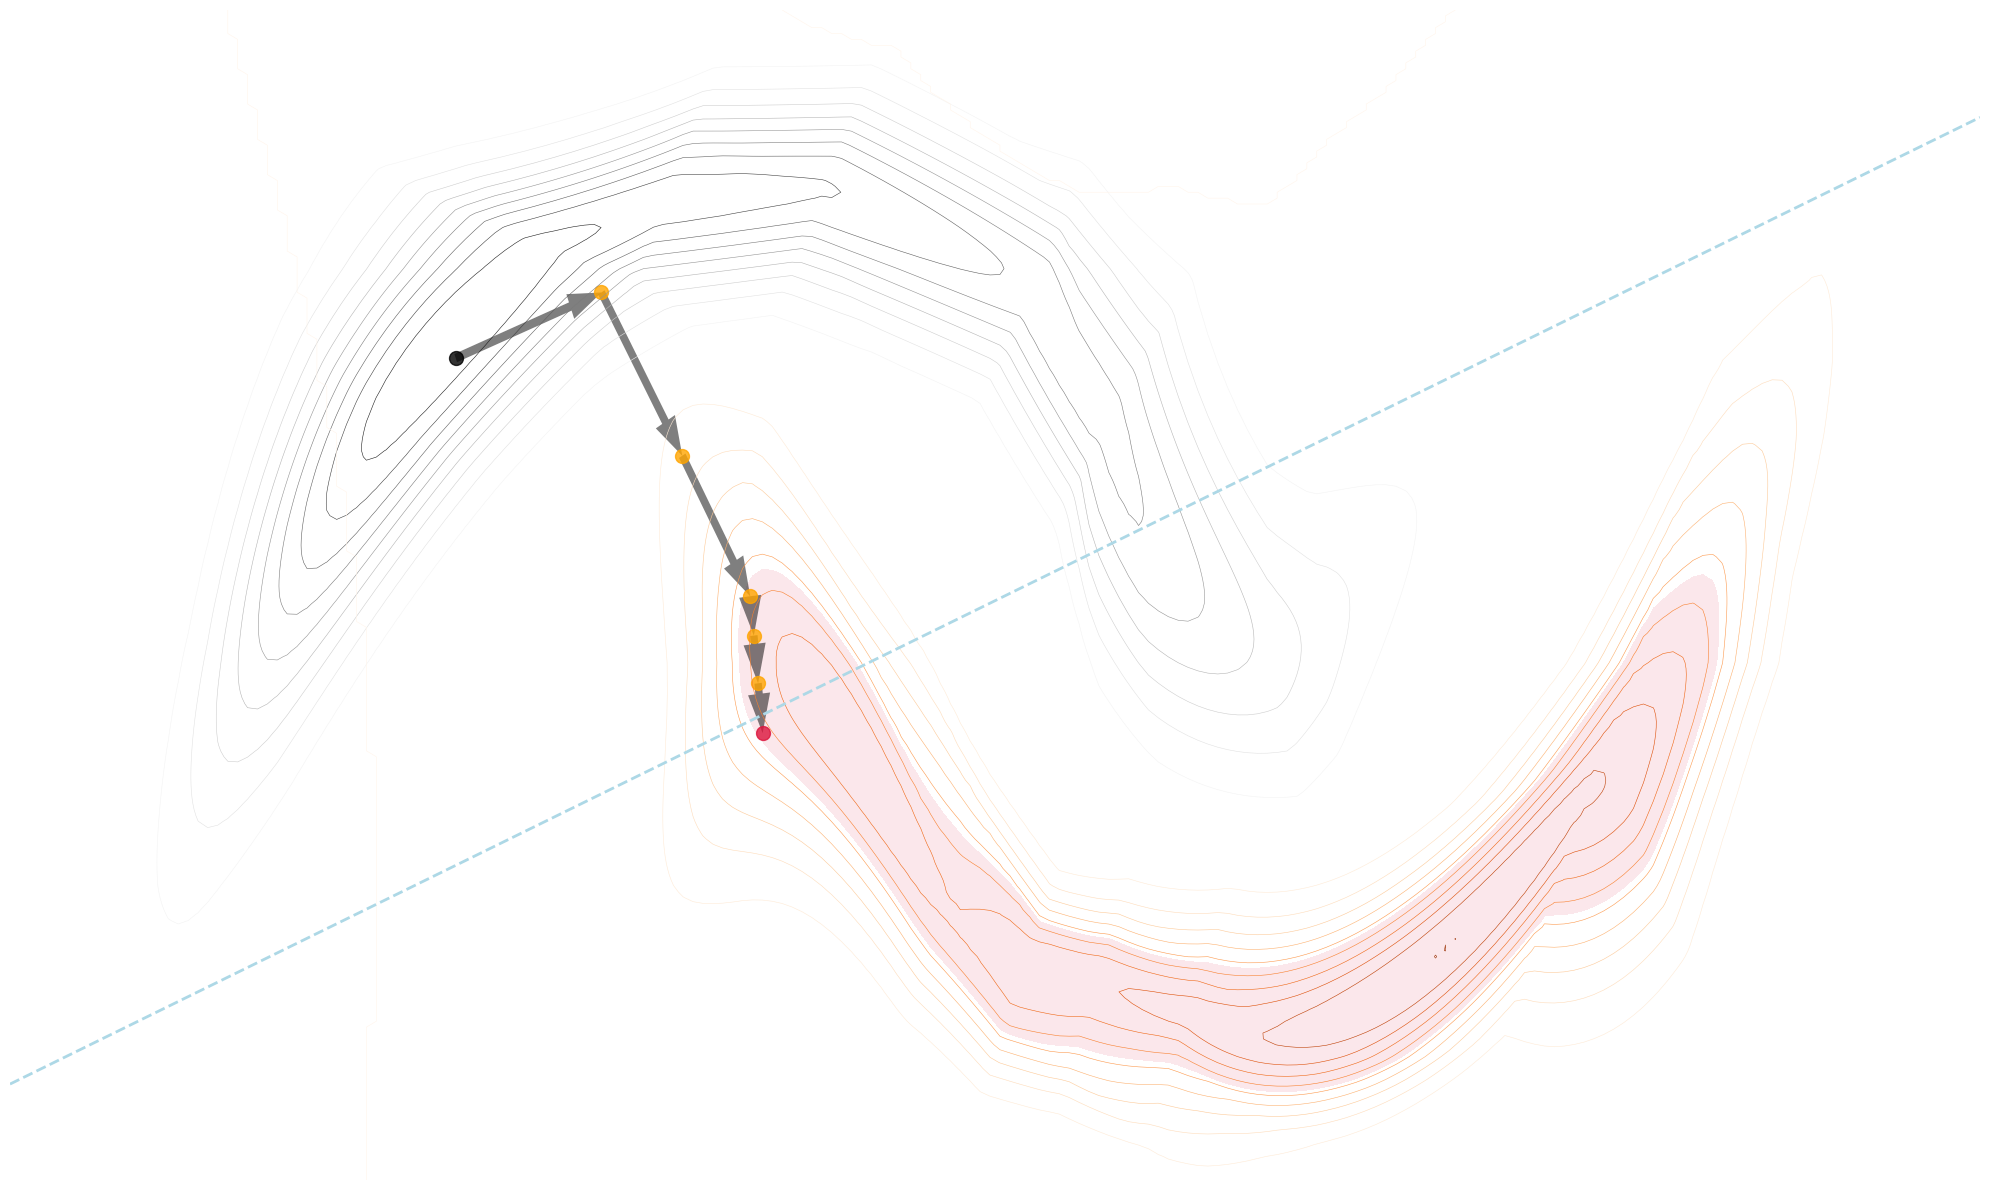

In [7]:
## Distribution Plot
ax = plot_model_distribution(cf.gen_model, median_prob, disc_model)

## Classifier Line
w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
c = -b/w2
m = -w1/w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, '#ADD8E6', lw=2.0, ls="dashed")
plt.axis("off")

## Arrows
for i in range(p_hist.shape[0]-1):
    ax.arrow(p_hist[i, 0], p_hist[i, 1], p_hist[i+1, 0]-p_hist[i, 0], p_hist[i+1, 1]-p_hist[i, 1], width=0.015, lw=0.001, length_includes_head=True, alpha=0.5, color="k")

ax.scatter(p_hist[0:1, 0], p_hist[0:1, 1], c="k", s=100, alpha=0.8)
ax.scatter(p_hist[1:-1, 0], p_hist[1:-1, 1], c="orange", s=100, alpha=0.8)
ax.scatter(p_hist[-1:, 0], p_hist[-1:, 1], c="#DC143C", s=100, alpha=0.8)
_ = ax.axis("off")

## Save Figure
plt.tight_layout()
plt.savefig('moons.pdf')